In [12]:
import gymnasium as gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [13]:
import gymnasium as gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ========================
# 1. State Normalizer
# ========================
class StateNormalizer:
    """Normalizes state values to help neural network training"""
    def __init__(self, state_size):
        self.state_size = state_size
        self.mean = np.zeros(state_size)  # Running mean of each state dimension
        self.var = np.ones(state_size)   # Running variance of each state dimension
        self.count = 0                   # Number of states seen
        
    def update(self, state):
        """Update running mean and variance with new state"""
        self.count += 1
        delta = state - self.mean
        self.mean += delta / self.count  # Update mean
        delta2 = state - self.mean
        self.var += (delta * delta2 - self.var) / self.count  # Update variance
        
    def normalize(self, state):
        """Convert state to normalized values (mean=0, std=1)"""
        if self.count == 0:
            return state
        std = np.sqrt(self.var + 1e-8)  # Standard deviation (small epsilon prevents division by zero)
        return (state - self.mean) / std

# ========================
# 2. Neural Network
# ========================
class DQN(nn.Module):
    """Deep Q-Network: predicts Q-values for each action given a state"""
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        # Three fully connected layers
        self.fc1 = nn.Linear(state_size, 64)   # Input layer: state -> 64 neurons
        self.fc2 = nn.Linear(64, 64)           # Hidden layer: 64 -> 64 neurons
        self.fc3 = nn.Linear(64, action_size)  # Output layer: 64 -> action Q-values
        
        # Initialize weights for better training stability
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        
    def forward(self, x):
        """Forward pass through the network"""
        x = torch.relu(self.fc1(x))  # Apply ReLU activation
        x = torch.relu(self.fc2(x))  # Apply ReLU activation
        return self.fc3(x)           # Output raw Q-values (no activation)

# ========================
# 3. Agent with Step-based Updates
# ========================
class Agent:
    """DQN Agent that learns to play CartPole using step-based training"""
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=50000)  # Store past experiences for replay learning
        
        # Q-learning parameters
        self.gamma = 0.99                 # Discount factor (how much we value future rewards)
        self.epsilon = 1.0                # Exploration rate (probability of random action)
        self.epsilon_min = 0.01           # Minimum exploration rate
        self.epsilon_decay = 0.999        # How fast exploration decreases
        self.learning_rate = 0.001        # Neural network learning rate
        self.batch_size = 64              # Number of experiences to learn from at once
        
        # Training schedule parameters
        self.collection_steps = 1500      # Collect random experiences first (exploration)
        self.target_update_freq = 1000    # How often to update target network
        self.training_freq = 4            # Train every N steps after collection phase
        
        # Training state tracking
        self.total_steps = 0
        self.training_started = False
        
        # Normalize states to help neural network learn better
        self.state_normalizer = StateNormalizer(state_size)

        # Use GPU if available, otherwise CPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Create two networks: main network and target network
        self.q_network = DQN(state_size, action_size).to(self.device)      # Main network (updated frequently)
        self.target_network = DQN(state_size, action_size).to(self.device) # Target network (updated slowly for stability)
        
        # Set up training components
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.SmoothL1Loss()  # Loss function for training
        
        # Copy main network weights to target network
        self.update_target_network()
        
    def update_target_network(self):
        """Copy weights from main network to target network (for stable learning)"""
        self.target_network.load_state_dict(self.q_network.state_dict())

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        # Normalize states before storing to help learning
        norm_state = self.state_normalizer.normalize(state)
        norm_next_state = self.state_normalizer.normalize(next_state)
        self.memory.append((norm_state, action, reward, norm_next_state, done))

    def act(self, state):
        """Choose an action using epsilon-greedy policy"""
        # Update our running statistics for state normalization
        self.state_normalizer.update(state)
        
        # Normalize the current state
        norm_state = self.state_normalizer.normalize(state)
        
        # Epsilon-greedy: sometimes explore (random action), sometimes exploit (best known action)
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Random action (exploration)
        
        # Use neural network to predict best action (exploitation)
        state_tensor = torch.FloatTensor(norm_state).unsqueeze(0).to(self.device)
        with torch.no_grad():  # Don't compute gradients for inference
            q_values = self.q_network(state_tensor)
        return torch.argmax(q_values).item()  # Return action with highest Q-value

    def step(self, state, action, reward, next_state, done):
        """Process one step and handle training logic"""
        # Store this experience in our memory
        self.remember(state, action, reward, next_state, done)
        self.total_steps += 1
        
        # Start training after we've collected enough random experiences
        if self.total_steps >= self.collection_steps and not self.training_started:
            self.training_started = True
            print(f"Training started at step {self.total_steps} with {len(self.memory)} experiences")
        
        # Train the network periodically (not every step to save computation)
        if (self.training_started and 
            self.total_steps % self.training_freq == 0 and 
            len(self.memory) >= self.batch_size):
            self.replay()
        
        # Update target network periodically for stable learning
        if self.total_steps % self.target_update_freq == 0:
            self.update_target_network()
            print(f"Target network updated at step {self.total_steps}")

    def replay(self):
        """Train the network using a batch of past experiences"""
        # Sample random batch of experiences from memory
        minibatch = random.sample(self.memory, self.batch_size)
        
        # Convert batch to tensors (states are already normalized)
        states = torch.FloatTensor([e[0] for e in minibatch]).to(self.device)
        actions = torch.LongTensor([e[1] for e in minibatch]).to(self.device)
        rewards = torch.FloatTensor([e[2] for e in minibatch]).to(self.device)
        next_states = torch.FloatTensor([e[3] for e in minibatch]).to(self.device)
        dones = torch.BoolTensor([e[4] for e in minibatch]).to(self.device)
        
        # Get current Q-values for the actions that were taken
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # Calculate target Q-values using Bellman equation: Q(s,a) = reward + gamma * max(Q(s',a'))
        with torch.no_grad():  # Don't compute gradients for target calculation
            max_next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * max_next_q_values * ~dones)  # If done, no future reward
        
        # Calculate loss and update network
        loss = self.loss_fn(current_q_values.squeeze(), target_q_values)
        
        self.optimizer.zero_grad()  # Clear previous gradients
        loss.backward()             # Compute gradients
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)  # Prevent exploding gradients
        self.optimizer.step()       # Update network weights

        # Reduce exploration over time (only during training phase)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [14]:
# ========================
# 4. Training Loop
# ========================
# Set up the CartPole environment and agent
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]  # 4 state variables: position, velocity, angle, angular velocity
action_size = env.action_space.n             # 2 actions: left or right
agent = Agent(state_size, action_size)

# Training parameters
episodes = 500
rewards_all = []      # Track reward for each episode
avg_rewards = []      # Track 100-episode moving average
step_rewards = []     # Track rewards vs steps

print("Starting DQN training...")
print(f"Collection phase: {agent.collection_steps} steps")
print(f"Target update frequency: {agent.target_update_freq} steps")

# Train for specified number of episodes
for e in range(episodes):
    # Reset environment for new episode
    state, _ = env.reset()
    state = np.array(state, dtype=np.float32)
    total_reward = 0
    
    # Run one episode (max 500 steps)
    for time in range(500):
        # Agent chooses action based on current state
        action = agent.act(state)
        
        # Take action in environment
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = np.array(next_state, dtype=np.float32)
        
        # Let agent learn from this experience
        agent.step(state, action, reward, next_state, done)
        
        # Update state and reward tracking
        state = next_state
        total_reward += reward
        
        # Track step-wise rewards for analysis
        if len(step_rewards) < agent.total_steps:
            step_rewards.extend([0] * (agent.total_steps - len(step_rewards)))
        if len(step_rewards) >= agent.total_steps:
            step_rewards[agent.total_steps - 1] = reward
        
        # End episode if CartPole falls over or time limit reached
        if done:
            break
    
    rewards_all.append(total_reward)
    
    # Calculate moving average to track learning progress
    if len(rewards_all) >= 100:
        avg_reward = np.mean(rewards_all[-100:])  # Average of last 100 episodes
        avg_rewards.append(avg_reward)
        
        # Print progress every 50 episodes
        if e % 50 == 0:
            training_status = "Training" if agent.training_started else "Collecting"
            print(f"Episode: {e+1}/{episodes}, Reward: {total_reward}, "
                  f"Avg(100): {avg_reward:.1f}, Steps: {agent.total_steps}, "
                  f"Status: {training_status}, Epsilon: {agent.epsilon:.3f}")
        
        # Check if problem is solved (average reward >= 195 over 100 episodes)
        if avg_reward >= 195:
            print(f"Environment solved at episode {e+1}!")
            print(f"Average reward over 100 episodes: {avg_reward:.1f}")
            print(f"Total steps taken: {agent.total_steps}")
            break
    else:
        # Print progress for early episodes (before we have 100 episodes)
        if e % 50 == 0:
            training_status = "Training" if agent.training_started else "Collecting"
            print(f"Episode: {e+1}/{episodes}, Reward: {total_reward}, "
                  f"Steps: {agent.total_steps}, Status: {training_status}, "
                  f"Epsilon: {agent.epsilon:.3f}")

Starting DQN training...
Collection phase: 1500 steps
Target update frequency: 1000 steps
Episode: 1/500, Reward: 13.0, Steps: 13, Status: Collecting, Epsilon: 1.000
Target network updated at step 1000
Episode: 51/500, Reward: 35.0, Steps: 1229, Status: Collecting, Epsilon: 1.000
Training started at step 1500 with 1500 experiences
Target network updated at step 2000
Episode: 101/500, Reward: 33.0, Avg(100): 22.3, Steps: 2245, Status: Training, Epsilon: 0.829
Target network updated at step 3000
Episode: 151/500, Reward: 33.0, Avg(100): 19.1, Steps: 3138, Status: Training, Epsilon: 0.664
Episode: 201/500, Reward: 12.0, Avg(100): 16.5, Steps: 3897, Status: Training, Epsilon: 0.549
Target network updated at step 4000
Episode: 251/500, Reward: 11.0, Avg(100): 16.8, Steps: 4817, Status: Training, Epsilon: 0.436
Target network updated at step 5000
Target network updated at step 6000
Episode: 301/500, Reward: 47.0, Avg(100): 25.5, Steps: 6449, Status: Training, Epsilon: 0.290
Target network up

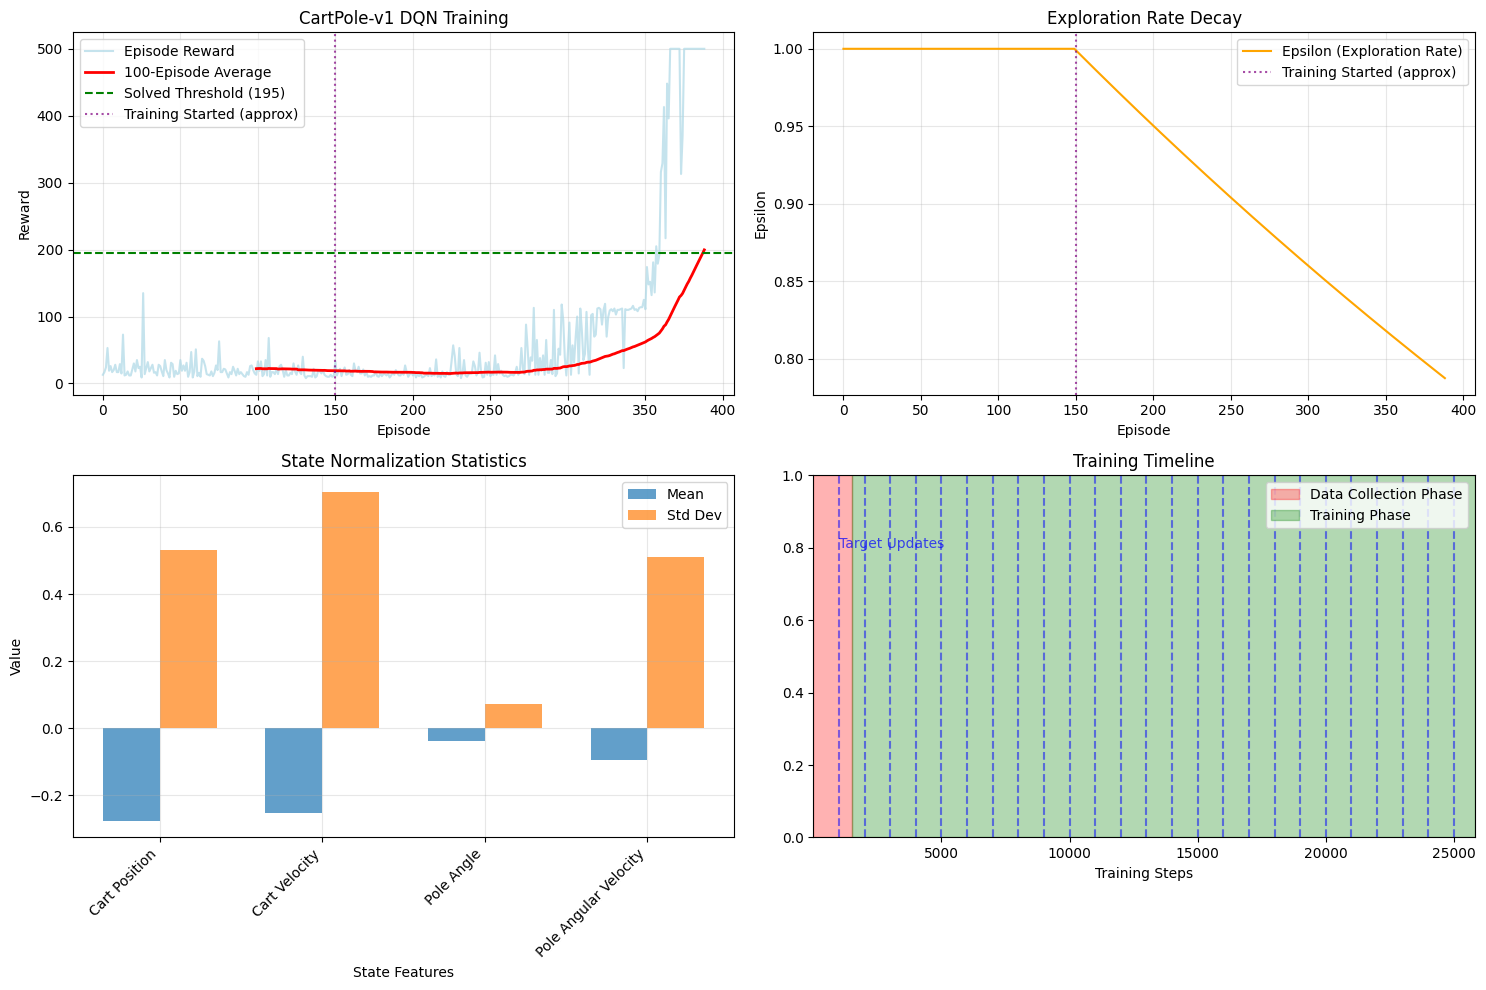


Training Summary:
Total steps: 25822
Collection phase: 1500 steps
Training started: Yes
Experiences collected: 25822
Final average reward: 199.6
State normalization - Mean: [-0.27652359 -0.25235349 -0.03768488 -0.0940344 ]
State normalization - Std: [0.5304487  0.7050408  0.07340529 0.5096237 ]


In [15]:
# ========================
# 5. Visualization
# ========================
plt.figure(figsize=(15, 10))

# Plot 1: Episode rewards over time
plt.subplot(2, 2, 1)
plt.plot(rewards_all, alpha=0.7, color='lightblue', label='Episode Reward')
if avg_rewards:
    plt.plot(range(99, len(rewards_all)), avg_rewards, color='red', linewidth=2, label='100-Episode Average')
plt.axhline(y=195, color='green', linestyle='--', label='Solved Threshold (195)')
plt.axvline(x=agent.collection_steps/10, color='purple', linestyle=':', alpha=0.7, label='Training Started (approx)')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("CartPole-v1 DQN Training")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Epsilon (exploration rate) decay over episodes
plt.subplot(2, 2, 2)
episodes_range = range(len(rewards_all))
epsilons = []
current_epsilon = 1.0
training_episodes = max(0, len(rewards_all) - agent.collection_steps//10)  # Approximate when training started
# Recreate epsilon values for visualization
for i in episodes_range:
    if i < agent.collection_steps//10:  # During collection phase
        epsilons.append(current_epsilon)  # Epsilon stays at 1.0
    else:  # During training phase
        current_epsilon = max(current_epsilon * agent.epsilon_decay, agent.epsilon_min)
        epsilons.append(current_epsilon)

plt.plot(epsilons, color='orange', label='Epsilon (Exploration Rate)')
plt.axvline(x=agent.collection_steps/10, color='purple', linestyle=':', alpha=0.7, label='Training Started (approx)')
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Exploration Rate Decay")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: State normalization statistics
plt.subplot(2, 2, 3)
state_names = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity']
means = agent.state_normalizer.mean
stds = np.sqrt(agent.state_normalizer.var)

x = np.arange(len(state_names))
width = 0.35

plt.bar(x - width/2, means, width, label='Mean', alpha=0.7)
plt.bar(x + width/2, stds, width, label='Std Dev', alpha=0.7)
plt.xlabel('State Features')
plt.ylabel('Value')
plt.title('State Normalization Statistics')
plt.xticks(x, state_names, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Training timeline showing different phases
plt.subplot(2, 2, 4)
steps_range = np.arange(1, agent.total_steps + 1)
collection_phase = steps_range <= agent.collection_steps
training_phase = steps_range > agent.collection_steps

# Color different training phases
plt.axvspan(1, agent.collection_steps, alpha=0.3, color='red', label='Data Collection Phase')
if agent.total_steps > agent.collection_steps:
    plt.axvspan(agent.collection_steps, agent.total_steps, alpha=0.3, color='green', label='Training Phase')

# Mark when target network was updated
target_updates = np.arange(agent.target_update_freq, agent.total_steps + 1, agent.target_update_freq)
for update_step in target_updates:
    plt.axvline(x=update_step, color='blue', linestyle='--', alpha=0.5)

plt.xlim(1, agent.total_steps)
plt.ylim(0, 1)
plt.xlabel('Training Steps')
plt.title('Training Timeline')
plt.legend()
if len(target_updates) > 0:
    plt.text(target_updates[0], 0.8, 'Target Updates', color='blue', alpha=0.7)

plt.tight_layout()
plt.savefig("training_results.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTraining Summary:")
print(f"Total steps: {agent.total_steps}")
print(f"Collection phase: {agent.collection_steps} steps")
print(f"Training started: {'Yes' if agent.training_started else 'No'}")
print(f"Experiences collected: {len(agent.memory)}")
print(f"Final average reward: {np.mean(rewards_all[-100:]) if len(rewards_all) >= 100 else np.mean(rewards_all):.1f}")
print(f"State normalization - Mean: {agent.state_normalizer.mean}")
print(f"State normalization - Std: {np.sqrt(agent.state_normalizer.var)}")

In [16]:
# ========================
# 6. Generate Video of Trained Agent
# ========================
import imageio

env.close()
env_render = gym.make("CartPole-v1", render_mode="rgb_array")

# Set agent to pure exploitation (no exploration)
agent.epsilon = 0  

frames = []
state, _ = env_render.reset()
state = np.array(state, dtype=np.float32)
terminated = truncated = False

print("\nGenerating video of trained agent...")

for step in range(500):  
    # Capture frame
    frame = env_render.render()
    frames.append(frame)
    
    # Get action from trained agent
    action = agent.act(state)
    
    # Take step
    state, reward, terminated, truncated, _ = env_render.step(action)
    state = np.array(state, dtype=np.float32)
    
    if terminated or truncated:
        print(f"Episode ended at step {step + 1}")
        break

env_render.close()

# Save video
if frames:
    imageio.mimsave("cartpole_trained_agent.gif", frames, fps=30)
    print(f"Video saved: cartpole_trained_agent.gif ({len(frames)} frames)")
    print(f"Agent survived {len(frames)} steps")
else:
    print("No frames captured. Check if rendering is working properly.")


Generating video of trained agent...


error: XDG_RUNTIME_DIR not set in the environment.


Episode ended at step 500
Video saved: cartpole_trained_agent.gif (500 frames)
Agent survived 500 steps
